In [3]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.distributions import Categorical
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [4]:
torch.manual_seed(0)

batch_size = 128
temperature = 1.0
seed = 0
log_interval = 100
log_interval_writer = 100
hard = False
latent_dim = 20
categorical_dim = 2
temp_min = 0.5
ANNEAL_RATE = 0.00003

g = 0.7

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Utilizzo Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Utilizzo NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Utilizzo la CPU")

# is_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
if device.type == "cuda": # Mantieni la seed per CUDA se presente
    torch.cuda.manual_seed(seed)
elif device.type == "mps": # Imposta la seed anche per MPS se vuoi riproducibilità
    torch.mps.manual_seed(seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if device.type == "cuda" or device.type == "mps" else {} # pin_memory può essere utile anche per MPS

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './data/MNIST',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True,
    **kwargs
    )

val_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './data/MNIST',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False,
    **kwargs
    )


Utilizzo Apple Silicon GPU (MPS)


## Gumbel softmax

In [5]:

def sample_gumbel(shape, eps=1e-20):
    # sample from a uniform distribution
    U = torch.rand(shape)
    return -torch.log(-torch.log(U.to(device) + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)


def gumbel_softmax(logits, temperature, hard=False):
    y = gumbel_softmax_sample(logits, temperature)
    
    if not hard:
        return y.view(-1, latent_dim * categorical_dim)
    
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    # skip the gradient of y_hard
    y_hard = (y_hard - y).detach() + y 
    return y_hard.view(-1, latent_dim * categorical_dim)



## alternative gumbel softmax

In [ ]:
def Gumbel_softmax(logits, tau, hard=False):
    U = torch.rand_like(logits)
    G = -torch.log(-torch.log(U + 1e-20) + 1e-20)
    y = F.softmax((logits + G) / tau, dim=-1)

    if hard:
        y_hard = torch.zeros_like(y)
        y_hard.scatter_(-1, y.argmax(dim=-1, keepdim=True), 1.0)
        y = (y_hard - y).detach() + y  # straight-through estimator

    return y


# HFM distribution

In [20]:
def mean_s_i(n, k, g): #0-indexed k
    '''
    n = total number of features
    k = k_th - 1 feature, 0-idexed
    g = constant in HFM distribution
    '''
    xi = 2 * np.exp(-g)
    if abs(xi - 1) < 1e-6: #handles the case xi =1
        E = (n - (k+1) + 2) / (2 * (n+1))
    else:
        E = 0.5 * (1 + (xi**(k) - 1) * (xi - 2) / (xi**n + xi -2))
    return E

In [ ]:
x = np.linspace(0.01,19)
plt.plot(x,mean_s_i(x))

# Class VAE

In [ ]:
class VAE_model(nn.Module):
    def __init__(self, ):
        super(VAE_model, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, latent_dim * categorical_dim)
        self.fc4 = nn.Linear(latent_dim * categorical_dim, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def sample_img(self, img, temp, random=True):
        with torch.no_grad():
            logits_z = self.encode(img.view(-1, 784))
            logits_z = logits_z.view(-1, latent_dim, categorical_dim)
            if random:
                latent_z = gumbel_softmax(logits_z, temp, True)
            else:
                latent_z = logits_z.view(-1, latent_dim * categorical_dim)
            logits_x = self.decode(latent_z)
            dist_x = torch.distributions.Bernoulli(probs=logits_x)
            sampled_img = dist_x.sample()
        return sampled_img

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return self.relu(self.fc3(h2))

    def decode(self, z):
        h4 = self.relu(self.fc4(z))
        h5 = self.relu(self.fc5(h4))
        return self.sigmoid(self.fc6(h5))

    def forward(self, data, temp, hard):
        logits_z = self.encode(data.view(-1, 784))
        logits_z = logits_z.view(-1, latent_dim, categorical_dim)

        probs_z = F.softmax(logits_z, dim=-1)
        posterior_distrib = torch.distributions.Categorical(probs=probs_z)

        prior_probs_list = []
        for i in range(latent_dim):
            prob_activation = mean_s_i(latent_dim,i,g)
            prob_nonactivation = 1 - prob_activation
            prior_probs_list.append([prob_activation, prob_nonactivation])

        probs_prior_base = torch.tensor(prior_probs_list, device=device, dtype=torch.float32)
        probs_prior = probs_prior_base.unsqueeze(0).expand(data.size(0), -1, -1)
        prior_distrib = torch.distributions.Categorical(probs=probs_prior)


        latent_z = gumbel_softmax(logits_z, temp)
        latent_z = latent_z.view(-1, latent_dim * categorical_dim)

        probs_x = self.decode(latent_z)
        dist_x = torch.distributions.Bernoulli(probs=probs_x, validate_args=False)

        rec_loss = dist_x.log_prob(data.view(-1, 784)).sum(dim=-1)
        logits_z_log = F.log_softmax(logits_z, dim=-1)

        #KL è la somma su tutte le (singole KL calcolate sulla distr di prob di bernoulli di ogni feature), non ancora sommata su ogni esempio del batch 
        KL = (posterior_distrib.probs * (logits_z_log - prior_distrib.probs.log())).view(-1, latent_dim * categorical_dim).mean(dim=-1)
        elbo = rec_loss - KL
        # a questo punto si fa la media su tutti i valori del batch
        loss = -elbo.mean()
        return loss, KL.mean(), rec_loss.mean()
    
    def sample_from_prior(self, num_samples=1, temp_eval=0.01):
        """
        Genera immagini campionando dallo spazio latente (prior).
        num_samples: Quante immagini vuoi generare.
        temp_eval: La temperatura da usare per la Gumbel-Softmax.
                Un valore molto basso (~0.01) simula un campionamento one-hot.
                Un valore di 1.0 rende il campionamento più "soft".
        """
        self.eval() # Imposta il modello in modalità valutazione
        with torch.no_grad(): # Non abbiamo bisogno di calcolare i gradienti qui

            prior_probs_list = []
            for i in range(latent_dim):
                prob_cat0 = mean_s_i(i)
                prob_cat1 = 1.0 - prob_cat0
                prior_probs_list.append([prob_cat0, prob_cat1])

            probs_prior_base = torch.tensor(prior_probs_list, device=device, dtype=torch.float32)

            sampled_indices = torch.distributions.Categorical(probs=probs_prior_base).sample((num_samples,)).to(device)
            # sampled_indices avrà forma (num_samples, latent_dim)

            # Converti gli indici campionati in un formato one-hot (o soft)
            # Per fare un sampling "hard" (one-hot), possiamo usare scatter_
            # o direttamente creare i one-hot da sampled_indices
            latent_z_one_hot = torch.zeros(num_samples, latent_dim, categorical_dim, device=device)
            latent_z_one_hot.scatter_(-1, sampled_indices.unsqueeze(-1), 1)

            latent_z_sampled = latent_z_one_hot.view(num_samples, latent_dim * categorical_dim)


            probs_x = self.decode(latent_z_sampled)

            dist_x = torch.distributions.Bernoulli(probs=probs_x)
            generated_img = dist_x.sample()

        self.train() # Riporta il modello in modalità addestramento
        return generated_img # Ritorna le immagini generate


# Training

In [17]:
writer = SummaryWriter(log_dir='runs/discrete_VAE/_20hid_with_mean_KL')

In [14]:
def train(model, optimizer, epochs):
    global_batch_idx = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        temp = temperature

        for batch_idx, (data, _) in enumerate(train_loader):
            global_batch_idx += 1
            # Sposta i dati sul device corretto
            data = data.to(device)
            optimizer.zero_grad()
            loss, KL, rec_loss = model(data, temp, hard)
            loss.backward()
            train_loss += loss.item() * len(data)
            optimizer.step()

            if batch_idx % 100 == 1:
                temp = np.maximum(temp * np.exp(-ANNEAL_RATE * batch_idx), temp_min)

            '''
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader),
                        loss.item()))
                print("Temperature : ", temp)
            '''

            if global_batch_idx % log_interval_writer == 0:
                writer.add_scalar('KL/Train', KL, global_step=global_batch_idx)
                writer.add_scalar('rec_loss/Train', rec_loss, global_step=global_batch_idx)


        writer.add_scalar('Loss/Train', train_loss/len(train_loader.dataset), global_step=epoch)



        '''
        # Sposta l'immagine campionata sulla CPU per la visualizzazione con matplotlib
        sampled = model.sample_img(data[0].view(-1, 28*28), temp).view(28, 28).detach().cpu()
        fig, axs = plt.subplots(1, 2, figsize=(6,4))
        fig.suptitle('Reconstructed vs Real')
        axs[0].imshow(sampled.reshape(28,28))
        axs[0].axis('off')
        axs[1].imshow(data[0].reshape(28,28).detach().cpu())
        axs[1].axis('off')
        plt.show()
        '''

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))
        
        # Validation
        
        model.eval()
        val_loss_sum = 0.0
        with torch.no_grad():
            for batch_idx, (data, _) in enumerate(val_loader):
                data = data.to(device)
                loss, KL, rec_loss = model(data, temp, hard=True)
                val_loss_sum += loss.item() * len(data)

        writer.add_scalar('Loss/Validation', val_loss_sum/len(val_loader.dataset), global_step=epoch)

        # Log histogram of weights and gradients
        for name, param in model.named_parameters():
            writer.add_histogram(f'Weights/{name}', param, global_step=epoch)
            if param.grad is not None:
                writer.add_histogram(f'Grads/{name}', param.grad, global_step=epoch)

    writer.close()
    print("Training completato e dati scritti su tensorboard")


                    
        

In [18]:


my_model = VAE_model()
my_model.to(device)
optimizer = optim.Adam(my_model.parameters(), lr=1e-3)

train(my_model, optimizer, epochs=15)

/Users/enricofrausin/Programmazione/Python_nn/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


====> Epoch: 0 Average loss: 200.2588
====> Epoch: 1 Average loss: 166.9122
====> Epoch: 2 Average loss: 144.9959
====> Epoch: 3 Average loss: 135.7206
====> Epoch: 4 Average loss: 131.5733
====> Epoch: 5 Average loss: 128.6622
====> Epoch: 6 Average loss: 126.2670
====> Epoch: 7 Average loss: 123.8236
====> Epoch: 8 Average loss: 121.6113
====> Epoch: 9 Average loss: 119.9646
====> Epoch: 10 Average loss: 118.5110
====> Epoch: 11 Average loss: 117.1469
====> Epoch: 12 Average loss: 115.8264
====> Epoch: 13 Average loss: 114.7393
====> Epoch: 14 Average loss: 113.7097
Training completato e dati scritti su tensorboard


# Validation

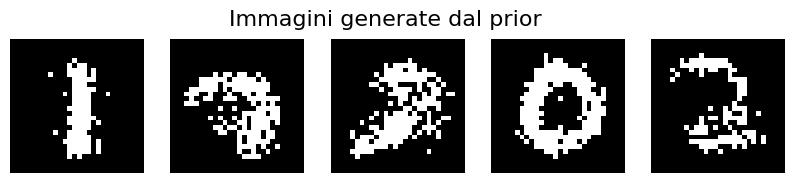

In [35]:
num_generated_images = 5
generated_images = my_model.sample_from_prior(num_samples=num_generated_images)

# Visualizza le immagini generate
plt.figure(figsize=(num_generated_images * 2, 2))
plt.suptitle("Immagini generate dal prior", fontsize=16)
for i in range(num_generated_images):
    plt.subplot(1, num_generated_images, i + 1)
    plt.imshow(generated_images[i].view(28, 28).detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()